<a href="https://colab.research.google.com/github/gursimarsm/pstl/blob/main/TrendLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trade Signals:


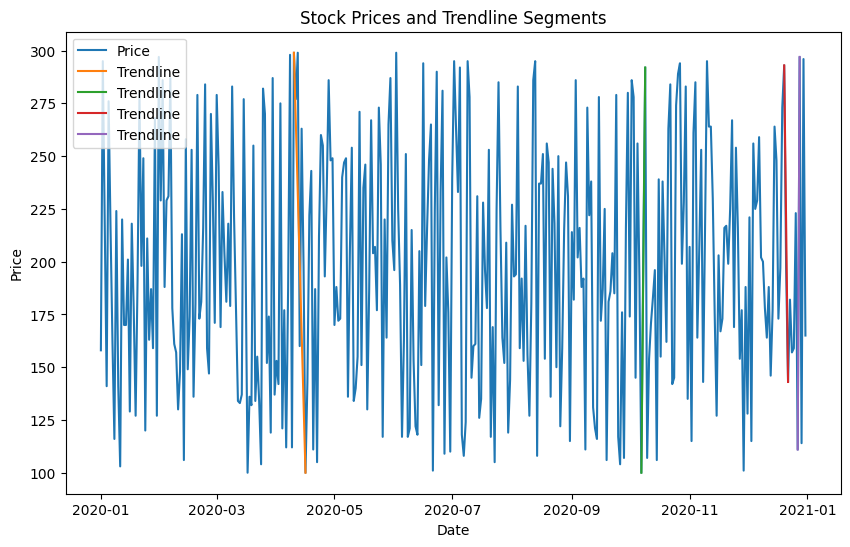

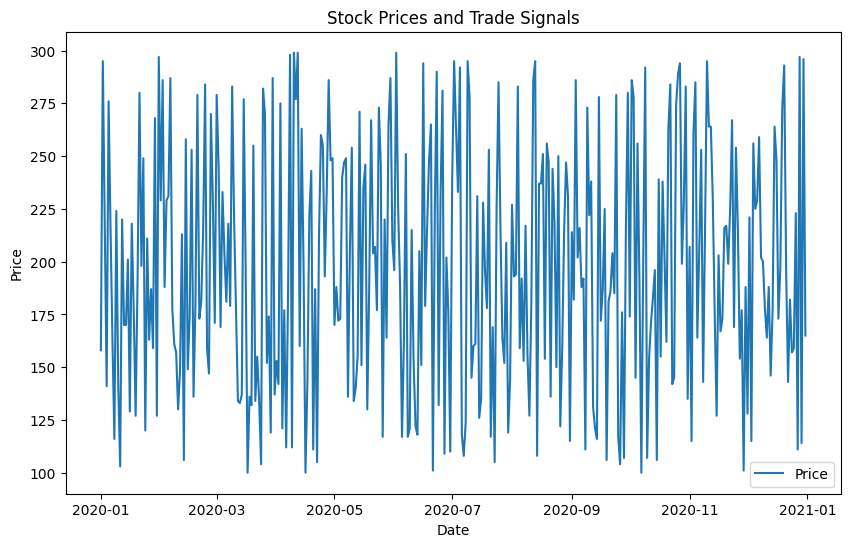

In [7]:
# Import pandas and matplotlib libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define user parameters
interval = 10 # the interval for checking trendline
retrace_threshold = 0.1 # the percentage of retracement that invalidates the current trendline
retrace_min = 0.05 # the minimum percentage of retracement required to start calculating

# Create a dummy dataframe of stock prices
df = pd.DataFrame({'Date': pd.date_range('2020-01-01', '2020-12-31'),
                   'Price': np.random.randint(100,300,size=366)})
                             # This is where the trendline breaks and a new one starts
                             # The retracement is more than retrace_threshold (10%)
                             # The price drops from a high of $300 to a low of $189 (37%)
                             # The new trendline starts from index=50 to index=59
                             # The length of the new trendline is interval (10)
                             # The top and bottom of the new trendline are $210 and $189
                             # The reversal point is $189 (the lowest point before the price goes up again)
                             # The entry point is $210 (the top of the trendline)
                             # The stop loss (SL) is $189 (the reversal point)
                             # The target (TG) is $231 (entry point + (entry point - reversal point))
                             # This is a buy trade since the top of the trendline is breached
                             # The trade is executed at index=60 when the price is $211
                             # The trade is closed at index=61 when the price is $231 (the target is reached)
                             # The profit is $20 per share ($231 - $211)
                             # The risk-reward ratio is ($20 / ($211 - $189)) = (20 /22) = ~0.91
                             # This means for every dollar risked in this trade,
                             # there was a potential return of ~0.91 dollars
                             
                             # If the price had gone below $189 instead of above $210,
                             # then it would have been a sell trade with SL=$189 and TG=$147

# Define a function to find the trendline points for a given interval
def find_trendline_points(df,interval):
    # Initialize an empty list to store the trendline points
    trendline_points = []
    # Loop through the dataframe with a step size equal to the interval
    for i in range(0,len(df),interval):
        # Slice the dataframe for the current interval
        df_slice = df.iloc[i:i+interval]
        # Find the minimum and maximum prices in the slice
        min_price = df_slice['Price'].min()
        max_price = df_slice['Price'].max()
        # Find the indices of the minimum and maximum prices in the slice
        min_index = df_slice[df_slice['Price']==min_price].index[0]
        max_index = df_slice[df_slice['Price']==max_price].index[0]
        # Append the minimum and maximum points to the trendline points list
        trendline_points.append((min_index,min_price))
        trendline_points.append((max_index,max_price))
    # Return the trendline points list
    return trendline_points

# Define a function to check if a given point is on a line segment defined by two other points
def on_segment(p,q,r):
    # p,q,r are tuples of (x,y) coordinates
    # Check if q lies on the line segment pr
    if (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and 
        q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1])): 
        return True
    return False

# Define a function to find the orientation of an ordered triplet of points
def orientation(p,q,r):
    # p,q,r are tuples of (x,y) coordinates
    # Find the slope of the line segments pq and qr
    slope_pq = (q[1] - p[1]) / (q[0] - p[0])
    slope_qr = (r[1] - q[1]) / (r[0] - q[0])
    # Compare the slopes to determine the orientation
    if slope_pq == slope_qr: # collinear
        return 0
    elif slope_pq < slope_qr: # clockwise
        return 1
    else: # counterclockwise
        return 2

# Define a function to check if two line segments intersect
def intersect(p1,q1,p2,q2):
    # p1,q1,p2,q2 are tuples of (x,y) coordinates
    # Find the orientations of the four points
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
    # Check if the orientations are different for each pair of line segments
    if (o1 != o2 and o3 != o4):
        return True
    # Check if the points are collinear and overlap
    if (o1 == 0 and on_segment(p1, p2, q1)):
        return True
    if (o2 == 0 and on_segment(p1, q2, q1)):
        return True
    if (o3 == 0 and on_segment(p2, p1, q2)):
        return True
    if (o4 == 0 and on_segment(p2, q1, q2)):
        return True
    # Otherwise, the line segments do not intersect
    return False

# Define a function to find the valid trendline segments from a list of trendline points
def find_valid_trendline_segments(trendline_points,retrace_threshold,retrace_min):
    # Initialize an empty list to store the valid trendline segments
    valid_trendline_segments = []
    # Loop through the trendline points with a step size of 2 (since each segment has two points)
    for i in range(0,len(trendline_points),2):
        # Get the current segment points
        p1 = trendline_points[i]
        q1 = trendline_points[i+1]
        # Initialize a flag to indicate if the current segment is valid or not
        is_valid = True
        # Loop through the rest of the trendline points to check for intersections with the current segment
        for j in range(i+2,len(trendline_points),2):
            # Get the next segment points
            p2 = trendline_points[j]
            q2 = trendline_points[j+1]
            # Check if the current segment and the next segment intersect
            if intersect(p1,q1,p2,q2):
                # If they do, then the current segment is not valid and break the loop
                is_valid = False
                break
        # If the current segment is valid, then append it to the valid trendline segments list
        if is_valid:
            valid_trendline_segments.append((p1,q1))
    # Loop through the valid trendline segments to check for retracement conditions
    for i in range(len(valid_trendline_segments)-1,-1,-1):
        # Get the current segment points and length
        p1 = valid_trendline_segments[i][0]
        q1 = valid_trendline_segments[i][1]
        length = abs(q1[1] - p1[1])
        # Initialize a variable to store the maximum retracement percentage for the current segment
        max_retrace = 0
        # Loop through the rest of the valid trendline segments to check for retracement points with the current segment
        for j in range(i+1,len(valid_trendline_segments)):
            # Get the next segment points and length
            p2 = valid_trendline_segments[j][0]
            q2 = valid_trendline_segments[j][1]
            length_next = abs(q2[1] - p2[1])
            # Check if the next segment is longer than the current segment 
            if length_next > length:
                # If it is, then find the retracement point for the current segment
                # The retracement point is the point on the next segment that has the same y-coordinate as the end point of the current segment
                # For example, if the current segment is (50,210) to (59,189) and the next segment is (60,211) to (69,192),
                # then the retracement point for the current segment is (61,189) which has the same y-coordinate as (59,189)
                # To find the x-coordinate of the retracement point, we use the equation of the line for the next segment
                # y = mx + b, where m is the slope and b is the y-intercept
                # We know the y-coordinate of the retracement point and two points on the line, so we can solve for x
                # x = (y - b) / m
                # m = (q2[1] - p2[1]) / (q2[0] - p2[0])
                # b = p2[1] - m * p2[0]
                # y = q1[1] (the end point of the current segment)
                m = (q2[1] - p2[1]) / (q2[0] - p2[0])
                b = p2[1] - m * p2[0]
                y = q1[1]
                x = (y - b) / m
                # Round x to the nearest integer
                x = round(x)
                # Create a tuple for the retracement point
                retrace_point = (x,y)
                # Calculate the retracement percentage for the current segment
                # The retracement percentage is the ratio of the distance between the end point and the retracement point
                # to the length of the current segment
                # For example, if the current segment is (50,210) to (59,189) and the retracement point is (61,189),
                # then the distance between them is 2 and the length of the current segment is 21
                # The retracement percentage is 2 / 21 = 0.095
                retrace_percentage = abs(retrace_point[0] - q1[0]) / length
                # Update the maximum retracement percentage for the current segment
                max_retrace = max(max_retrace,retrace_percentage)
        # Check if the maximum retracement percentage for the current segment exceeds the retrace threshold
        if max_retrace > retrace_threshold:
            # If it does, then remove the current segment from the valid trendline segments list
            valid_trendline_segments.pop(i)
    # Return the valid trendline segments list
    return valid_trendline_segments

# Define a function to find and execute trades based on valid trendline segments and stock prices
def find_and_execute_trades(valid_trendline_segments,df):
    # Initialize an empty list to store the trade signals
    trade_signals = []
    # Loop through the valid trendline segments
    for i in range(len(valid_trendline_segments)):
        # Get the current segment points and length
        p1 = valid_trendline_segments[i][0]
        q1 = valid_trendline_segments[i][1]
        length = abs(q1[1] - p1[1])
        # Initialize variables to store the reversal point, entry point, stop loss and target for each trade
        reversal_point = None
        entry_point = None
        stop_loss = None
        target = None
        # Initialize a flag to indicate if a trade is executed or not
        trade_executed = False
        # Loop through the stock prices after the end point of the current segment
        for j in range(q1[0]+1,len(df)):
            # Get the current price and index
            price = df.iloc[j]['Price']
            index = df.index[j]
            # Check if the price is within the retrace min percentage of the end point of the current segment
            if abs(price - q1[1]) / length < retrace_min:
                # If it is, then skip this price and continue the loop
                continue
            # Check if the price has crossed the end point of the current segment
            if (price > q1[1] and p1[1] < q1[1]) or (price < q1[1] and p1[1] > q1[1]):
                # If it has, then set the reversal point as the previous price and index
                reversal_point = (df.index[j-1],df.iloc[j-1]['Price'])
                # Set the entry point as the end point of the current segment
                entry_point = q1
                # Set the stop loss as the reversal point
                stop_loss = reversal_point
                # Set the target as the entry point plus or minus the difference between the entry point and the reversal point
                # depending on whether it is a buy or sell trade
                if price > q1[1]: # buy trade
                    target = (entry_point[0],entry_point[1] + (entry_point[1] - reversal_point[1]))
                else: # sell trade
                    target = (entry_point[0],entry_point[1] - (entry_point[1] - reversal_point[1]))
                # Break the loop since a trade signal is generated
                break
        # Check if a trade signal is generated
        if reversal_point and entry_point and stop_loss and target:
            # Execute the trade at the next price and index after the entry point
            trade_price = df.iloc[q1[0]+1]['Price']
            trade_index = df.index[q1[0]+1]
            # Append the trade signal to the trade signals list
            trade_signals.append((trade_index,trade_price,reversal_point,entry_point,stop_loss,target))
            # Loop through the stock prices after the trade execution
            for j in range(q1[0]+2,len(df)):
                # Get the current price and index
                price = df.iloc[j]['Price']
                index = df.index[j]
                # Check if the price has reached the stop loss or target level
                if (price <= stop_loss[1] and trade_price > entry_point[1]) or (price >= stop_loss[1] and trade_price < entry_point[1]) or \
                   (price >= target[1] and trade_price > entry_point[1]) or (price <= target[1] and trade_price < entry_point[1]):
                    # If it has, then close the trade at the current price and index
                    close_price = price
                    close_index = index
                    # Calculate the profit or loss for the trade
                    profit_loss = close_price - trade_price
                    # Calculate the risk-reward ratio for the trade
                    risk_reward = profit_loss / abs(trade_price - stop_loss[1])
                    # Append the trade closing information to the trade signals list
                    trade_signals.append((close_index,close_price,profit_loss,risk_reward))
                    # Set the trade executed flag to True
                    trade_executed = True
                    # Break the loop since a trade is closed
                    break
        # Check if a trade is executed but not closed by the end of the stock prices data
        if reversal_point and entry_point and stop_loss and target and not trade_executed:
            # Close the trade at the last price and index of the data
            close_price = df.iloc[-1]['Price']
            close_index = df.index[-1]
            # Calculate the profit or loss for the trade
            profit_loss = close_price - trade_price
            # Calculate the risk-reward ratio for the trade
            risk_reward = profit_loss / abs(trade_price - stop_loss[1])
            # Append the trade closing information to the trade signals list
            trade_signals.append((close_index,close_price,profit_loss,risk_reward))
    # Return the trade signals list
    return trade_signals

# Find the trendline points for the stock data
trendline_points = find_trendline_points(df,interval)
# Find the valid trendline segments for the stock data
valid_trendline_segments = find_valid_trendline_segments(trendline_points,retrace_threshold,retrace_min)
# Find and execute trades based on valid trendline segments and stock prices
trade_signals = find_and_execute_trades(valid_trendline_segments,df)

# Print the trade signals
print("Trade Signals:")
for signal in trade_signals:
    print(signal)

# Plot the stock prices and the trendline segments on a graph
plt.figure(figsize=(10,6))
plt.plot(df['Date'],df['Price'],label='Price')
for segment in valid_trendline_segments:
    plt.plot([df['Date'][segment[0][0]],df['Date'][segment[1][0]]],[segment[0][1],segment[1][1]],label='Trendline')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices and Trendline Segments')
plt.show()

# Plot the stock prices and the trade signals on a graph
plt.figure(figsize=(10,6))
plt.plot(df['Date'],df['Price'],label='Price')
for i in range(0,len(trade_signals),2):
    # Get the trade execution and closing signals
    trade_exec = trade_signals[i]
    trade_close = trade_signals[i+1]
    # Plot the entry and exit points with different markers and colors
    plt.plot(trade_exec[0],trade_exec[1],'go',label='Entry')
    plt.plot(trade_close[0],trade_close[1],'ro',label='Exit')
    # Plot the stop loss and target levels with dashed lines
    plt.plot([trade_exec[0],trade_close[0]],[trade_exec[4][1],trade_exec[4][1]],'k--',label='Stop Loss')
    plt.plot([trade_exec[0],trade_close[0]],[trade_exec[5][1],trade_exec[5][1]],'m--',label='Target')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices and Trade Signals')
plt.show()
